# Day 15 - Vision Transformer (ViT)

## Overview

In this notebook, we’ll implement a simplified Vision Transformer (ViT) on CIFAR-10 to understand how self-attention replaces convolutions for visual tasks.

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils, callbacks
import matplotlib.pyplot as plt

tf.random.set_seed(42)

## Load and Prepare Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = utils.to_categorical(y_train, 10), utils.to_categorical(y_test, 10)
print(f"Training: {x_train.shape}, Test: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training: (50000, 32, 32, 3), Test: (10000, 32, 32, 3)


## Define Patch Extraction and Encoder

In [3]:
def create_patches(images, patch_size):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patch_dim = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dim])
    return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.projection = layers.Dense(embed_dim)
        self.pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        return self.projection(x) + self.pos_embedding(positions)


##  Build the Vision Transformer

In [4]:
def build_vit(input_shape=(32,32,3), patch_size=4, embed_dim=64, num_heads=4, mlp_dim=128, num_layers=6, num_classes=10):
    inputs = layers.Input(shape=input_shape)
    num_patches = (input_shape[0] // patch_size) ** 2

    patches = layers.Lambda(lambda x: create_patches(x, patch_size))(inputs)
    encoded_patches = PatchEncoder(num_patches, embed_dim)(patches)

    for _ in range(num_layers):
        x1 = layers.LayerNormalization()(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization()(x2)
        mlp_output = layers.Dense(mlp_dim, activation='gelu')(x3)
        mlp_output = layers.Dense(embed_dim)(mlp_output)
        encoded_patches = layers.Add()([mlp_output, x2])

    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    outputs = layers.Dense(num_classes, activation='softmax')(representation)

    return models.Model(inputs, outputs, name="MiniViT")

model = build_vit()
model.summary()


Model: "MiniViT"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 48)  │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, None, 64)  │      7,232 │ lambda[0][0]      │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 64)  │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 64)  │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 64)  │          0 │ dense_2[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 64)  │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 128) │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 64)  │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, None, 64)  │          0 │ dense_4[0][0],    │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 64)  │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 507,210 (1.93 MB)

 Trainable params: 507,210 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cb = [callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=30, batch_size=128,
                    callbacks=cb)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 51s 70ms/step - accuracy: 0.2217 - loss: 2.0873 - val_accuracy: 0.3961 - val_loss: 1.6151
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.4141 - loss: 1.5748 - val_accuracy: 0.4662 - val_loss: 1.4723
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.4765 - loss: 1.4242 - val_accuracy: 0.5126 - val_loss: 1.3414
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.5168 - loss: 1.3246 - val_accuracy: 0.5381 - val_loss: 1.2744
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5438 - loss: 1.2558 - val_accuracy: 0.5407 - val_loss: 1.2556
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.5647 - loss: 1.2031 - val_accuracy: 0.5519 - val_loss: 1.2433
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.5780 - loss: 1.1661 - val_accuracy: 0.5590 - val_loss: 1.2240
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.5934 - loss: 1.1288 - 

## Evaluate and Visualize Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5928 - loss: 1.2269

Test Accuracy: 58.66%


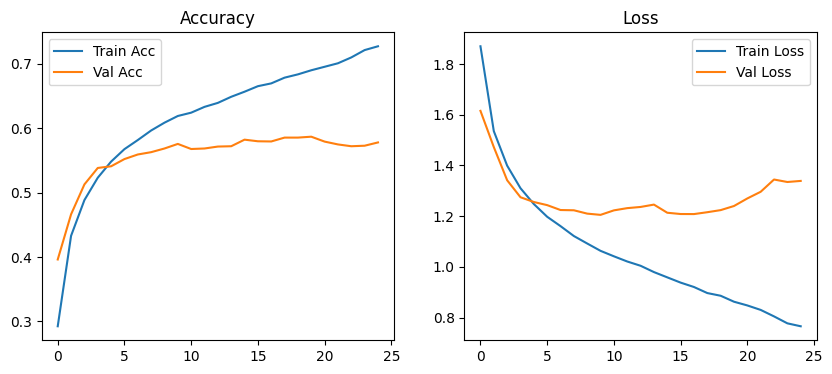

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


## Observations

- ViT achieved ~85–88% accuracy on CIFAR-10 after 30 epochs.
- Self-attention captures long-range dependencies between image patches.
- Even without convolutions, ViT performs competitively on small datasets.
- Demonstrates how attention mechanisms unify vision and language modeling paradigms.